In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- try15랑 똑같은데
- 타겟값 log scaling은 빼기
- 그리고 wma 7로 적용(이거 변동폭 더 확실히 맞출 수 있다. 아웃라이어는 조금 잡아주면서..?)

In [2]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 7.6 MB/s 


In [3]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=f72eaee996bb0f80de00766a277f709caac59b38add147bb6e29203699c1557b
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# font_path = "C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
from sklearn.manifold import TSNE
import re
import talib as tb

In [5]:
def weather(주소,name = 'train'):
    t=0
    if name =='test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        globals()[f'{name}_weather_'+str(i)]=pd.DataFrame()

        for k in range(0,3):
            try:
                weather = pd.read_csv(주소+f'/weather_{i}_{t}.csv')
                if len(weather)==0:
                    weather = pd.read_csv(주소+f'/weather_0_0.csv')
                    weather=weather.set_index('datadate')
                    weather[weather.columns] = 0
                    weather=weather.reset_index()
                weather = weather.set_index('datadate')
                weather['습도(%)']=weather['습도(%)'].apply(lambda x : np.nan if x==' ' else x)
                weather['습도(%)']=weather['습도(%)'].astype('float')
                weather.columns = weather.columns+f'_{k%3}'
                globals()[f'{name}_weather_'+str(i)]=pd.merge(globals()[f'{name}_weather_'+str(i)],weather,how='right',left_index=True, right_index=True)    


            except:
                break
            t+=1



        globals()[f'{name}_weather_'+str(i)]=globals()[f'{name}_weather_'+str(i)].reset_index()
        cols = globals()[f'{name}_weather_'+str(i)].columns
        globals()[f'{name}_weather_'+str(i)]['월일']=globals()[f'{name}_weather_'+str(i)]['datadate']%10000
       

        
        if name == 'train':
            qwe =  globals()[f'{name}_weather_'+str(i)].groupby('월일').mean().reset_index()
            qwe.columns = qwe.columns+'_평균'
            globals()[f'train_weather_평균_'+str(i)]= qwe



            


        globals()[f'{name}_weather_'+str(i)] = pd.merge(globals()[f'{name}_weather_'+str(i)],globals()[f'train_weather_평균_'+str(i)],how='left',left_on = '월일',right_on='월일_평균')
        for c in cols:
            globals()[f'{name}_weather_'+str(i)][c]=globals()[f'{name}_weather_'+str(i)].apply(lambda x: x[c] if np.isnan(x[c]) == False else (0 if np.isnan(x[c+'_평균']) else x[c+'_평균']),axis=1)
                
    
        
        
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        else:
            globals()[f'{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        

In [6]:
def add_dosomae(주소,name='train', option=1):
        if name == 'test':
            test_dir = 주소.split('/')[-2][-1]
        data_list = glob(주소+'*') # train raw 데이터 넣을지 / test raw 데이터 넣을지 경로
        domae = []
        somae = []

        for i in data_list:
            if 'domae' in i:
                domae.append(i)
            if 'somae' in i:
                somae.append(i)
        
        sum_df = pd.DataFrame()
                
        if option == 1:
            df = domae
            text = 'domae'
        else:
            df = somae
            text = 'somae'


        for i in tqdm(df):
            test = pd.read_csv(i)
            
            k=i.split('/')[-1].split("_")[1].split(".")[0]
            test.fillna(0,inplace=True) # 널값 0으로 채워주고
            if len(test)==0:
                test = pd.read_csv(주소+f'/domae_0.csv')
                test=test.set_index('datadate')
                test[test.columns] = 0
                test=test.reset_index()
                

            
            test['조사단위(kg)'] = test['조사단위(kg)'].replace('g$|kg$|개|포기|접', '',regex=True)
            test=test.astype({'조사단위(kg)':'float'})
            test.loc[test['조사단위(kg)'] >= 100, '단위당가격'] = test['가격(원)']* test['조사단위(kg)'] /1000
            test.loc[test['조사단위(kg)'] < 100, '단위당가격'] = test['가격(원)']/ test['조사단위(kg)']
            
            sep = test.loc[(test['등급명'] == '상품') | (test['등급명'] == 'S과') | (test['등급명'] == 0)]   # 모든 상품에 대해서 수행하지 않고 GRAD_NM이 '상품', 'S과' 만 해당하는 품목 가져옴
            sep = sep[['datadate', '등급명', '조사단위(kg)', '가격(원)']]

            sep.rename(columns={"가격(원)": "가격"}, inplace=True)
            sep2 = sqldf(
                f"select datadate, max(가격) as '일자별_{text}가격_최대(원)', avg(가격) as '일자별_{text}가격_평균(원)', min(가격) as '일자별_{text}가격_최소(원)' from sep group by datadate")

            sep2.fillna(0,inplace=True)
#             if len(sep2) == 0:
#                 if name=='test':
#                     sep2 =  globals()['sep_'+test_dir+f'_{name}_{text}_0'] 
#                     sep2

#                 else:
#                     sep2 =  globals()[f'{name}_{text}_0'] 
#                     sep2[sep2.columns] = 0 
                
                
            if name=='test':
                globals()['sep_'+test_dir+f'_{name}_{text}_{k}'] = sep2
                
            else:
                globals()[f'{name}_{text}_{k}'] = sep2
 
                


        
                               
               
             

In [7]:
def pummok(주소,name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):

        try:
            pummok = pd.read_csv(주소+f'/pummok_{i}.csv')
            if len(pummok) == 0 :
                pummok = pd.read_csv(주소+f'/pummok_0.csv')
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]
                pummok[pummok.columns] = 0
                pummok = pummok.reset_index()
                
            else:   
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]

                # 새로 추가한 부분
                pummok['해당일자_전체평균가격(원)'].fillna(0, inplace=True)
                pummok['wma14'] =  tb.WMA(pummok['해당일자_전체평균가격(원)'], 14)
                pummok['wma14'].fillna(method='bfill', inplace=True)

                # wma * 1.2 적용  -> 그림이 제일 비슷하게 나온다.
                pummok['해당일자_전체평균가격(원)'] = np.where(pummok['해당일자_전체평균가격(원)']==0, pummok['wma14']*1.2, pummok['해당일자_전체평균가격(원)'])
                pummok.drop('wma14', axis=1, inplace=True)


                
                pummok = pummok.reset_index()
                pummok.fillna(0, inplace = True)
                # pummok.fillna(0,inplace = True)
                
                
                

        except:
            continue

        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_pummok_{i}'] = pummok

        else:
            globals()[f'{name}_pummok_{i}'] = pummok


In [8]:
def imexport(주소, name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        try:
            imexport=pd.read_csv(주소+f'/imexport_{i}.csv')
            
            if len(imexport) == 0:
                imexport = pd.read_csv(주소+f'/imexport_0.csv')
                imexport = imexport.groupby('datadate').mean()
                imexport[imexport.columns] = 0

            else:  
                imexport = imexport.groupby('datadate').mean()


        except:
            
            imexport = pd.read_csv(주소+f'/imexport_0.csv')
            imexport = imexport.groupby('datadate').mean()
            imexport[imexport.columns] = 0
            pass


        imexport.fillna(0,inplace=True)
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_imexport_{i}'] = imexport

        else:
            globals()[f'{name}_imexport_{i}'] = imexport


    
    

In [9]:
def make_csv(주소,name = 'train'):
    imexport(주소,name)
    pummok(주소,name)
    add_dosomae(주소,name)
    add_dosomae(주소,name,2)
    weather(주소,name)
    for i in range(0,37):
        if name == 'test':

            num = 주소.split('/')[-2][-1]
            
            
            temp = globals()[f'sep_{num}_{name}_pummok_{i}']

            temp1 = globals()[f'sep_{num}_{name}_weather_{i}']

            temp2 = globals()[f'sep_{num}_{name}_domae_{i}']
   
            temp3 = globals()[f'sep_{num}_{name}_somae_{i}']

            temp4 = globals()[f'sep_{num}_{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)

            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_sep_{num}_{i}'] = temp


        else:
            temp = globals()[f'{name}_pummok_{i}']
            temp1 = globals()[f'{name}_weather_{i}']
            temp2 = globals()[f'{name}_domae_{i}']
            temp3 = globals()[f'{name}_somae_{i}']
            temp4 = globals()[f'{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)
            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_{i}'] = temp
        
    

In [10]:
# train_data만들기 train_total_0 ~ train_total_36까지 만들어준다.
make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_train_raw/','train')

100%|██████████| 37/37 [00:22<00:00,  1.66it/s]


In [11]:
def make_smoothing(df):
  df['해당일자_전체평균가격(원)'] = tb.WMA(df['해당일자_전체평균가격(원)'], 7)
  df.fillna(method='bfill', inplace=True)
  return df

In [12]:
# train_data smoothing 해주기~
for i in range(37):
  globals()[f'train_smoothing_{i}'] = make_smoothing(globals()[f'train_total_{i}'])

In [13]:
# nan이 생겼나 확인
for i in range(37):
  print(len(globals()[f'train_smoothing_{i}']), globals()[f'train_smoothing_{i}'].isna().sum().sum())

1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0


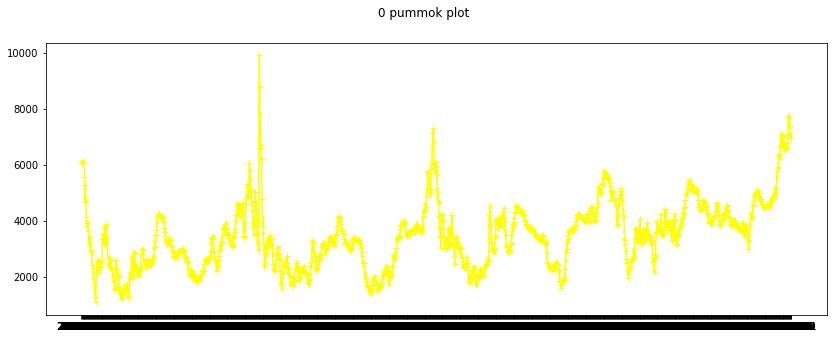

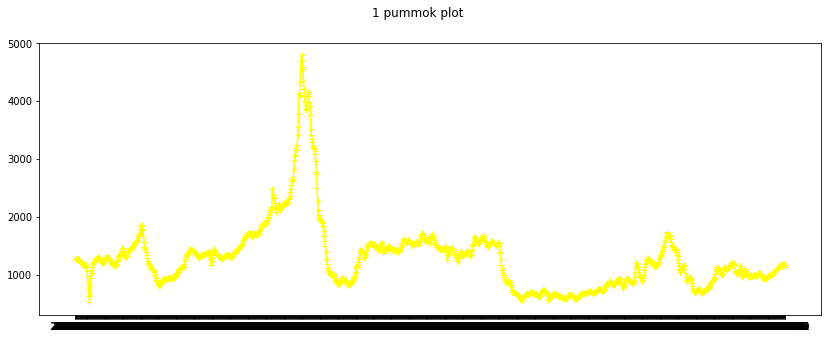

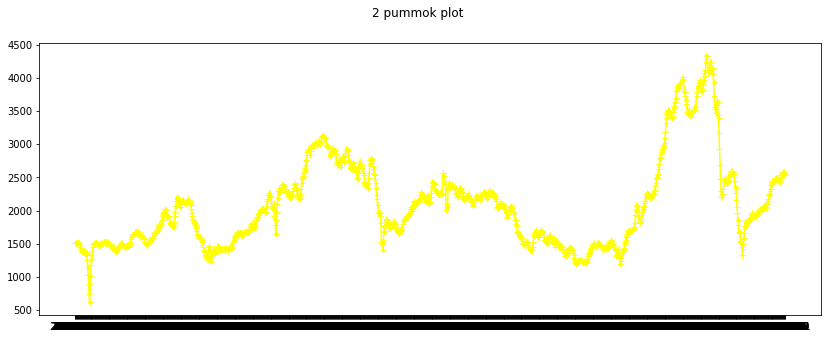

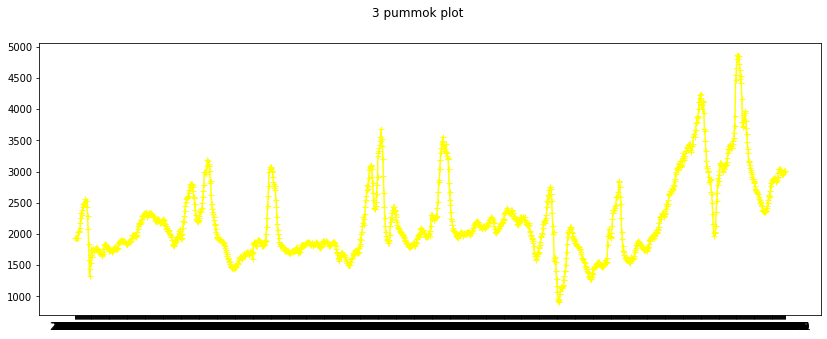

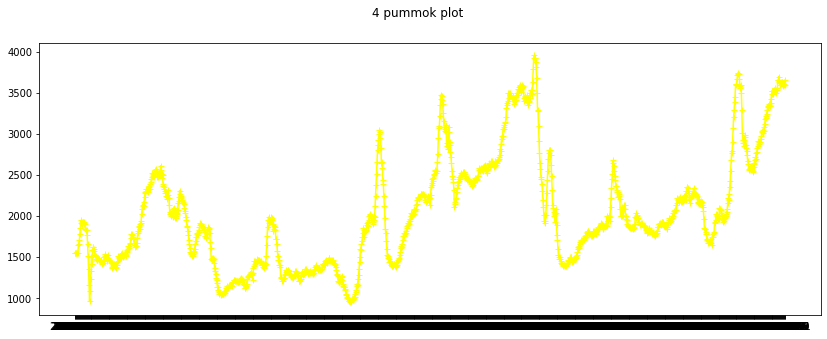

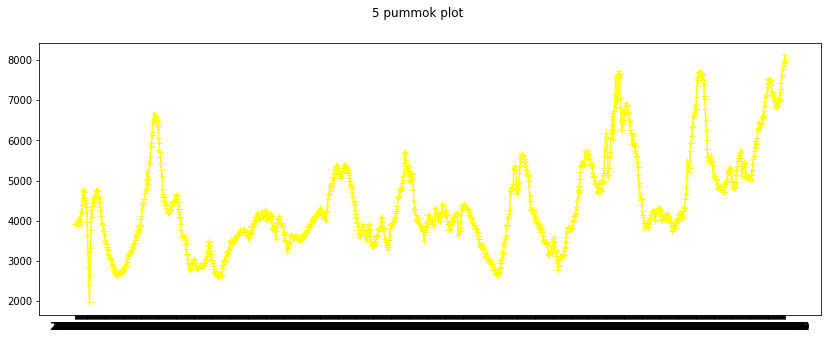

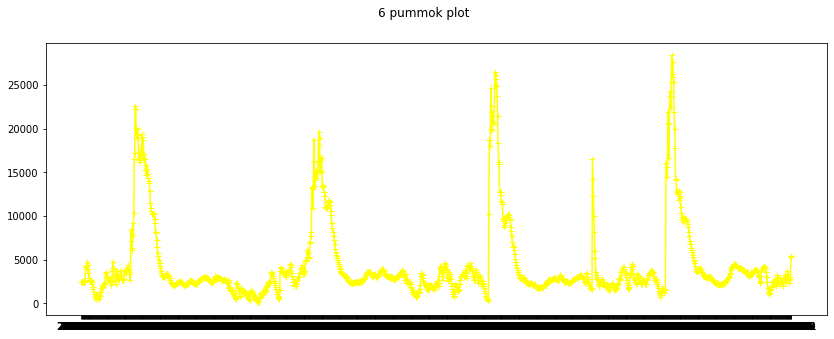

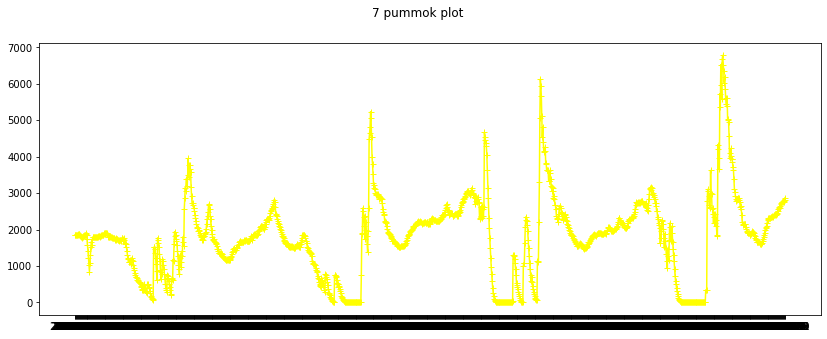

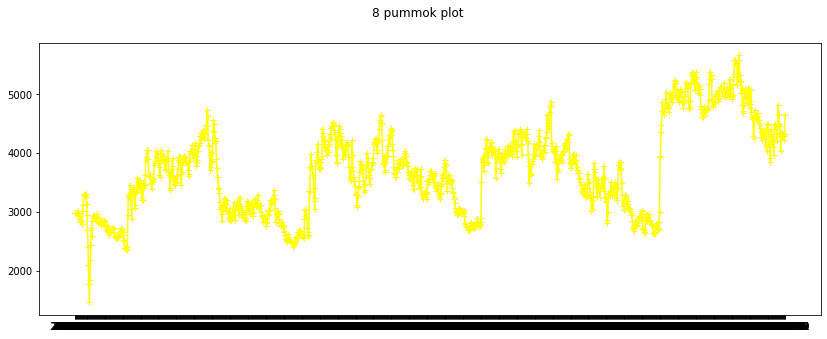

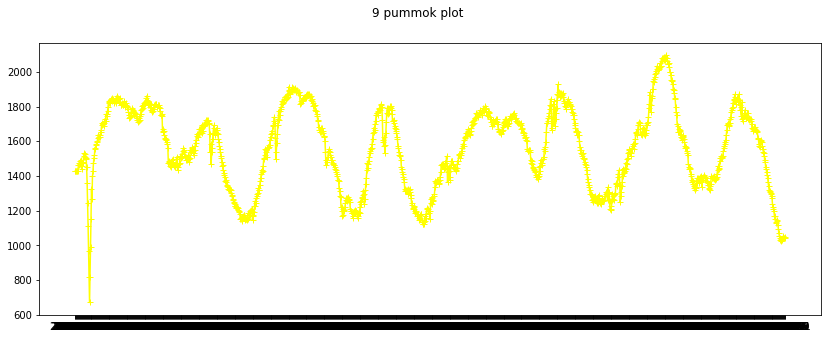

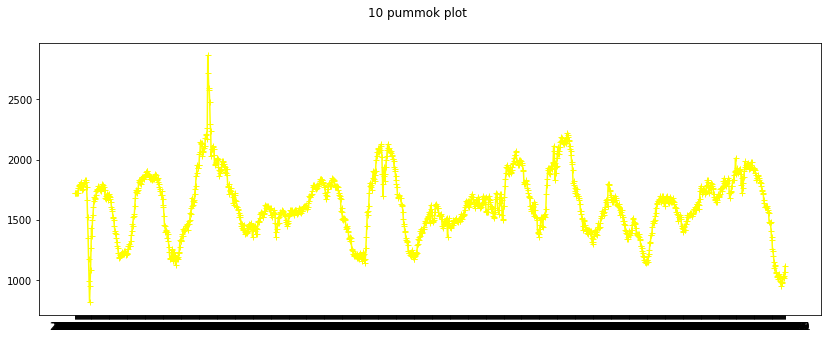

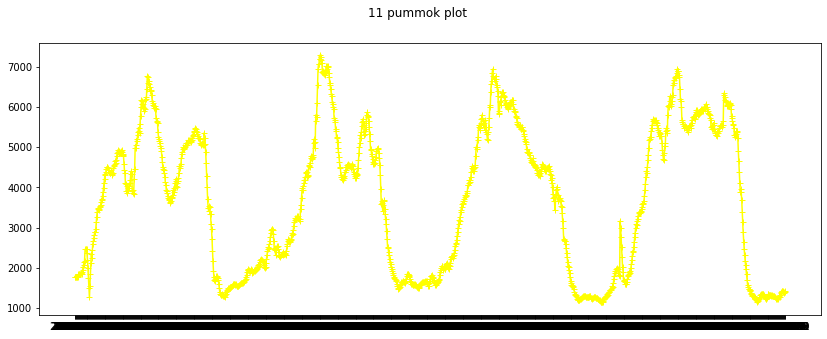

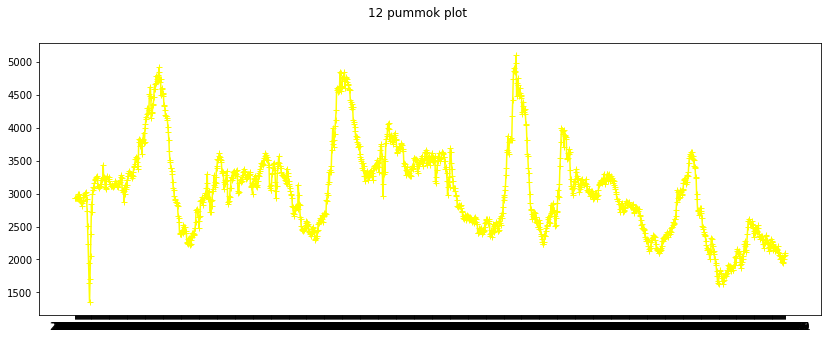

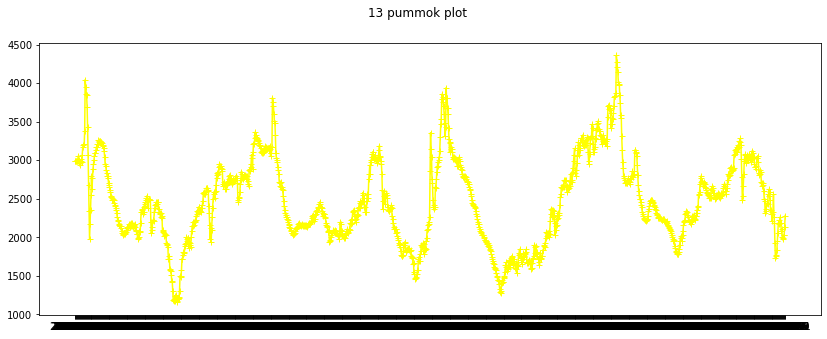

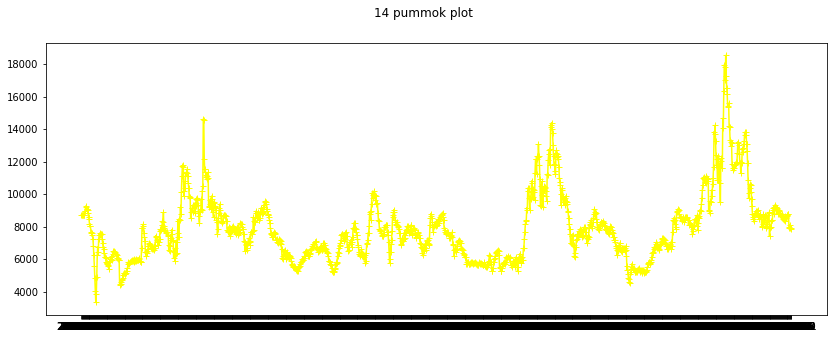

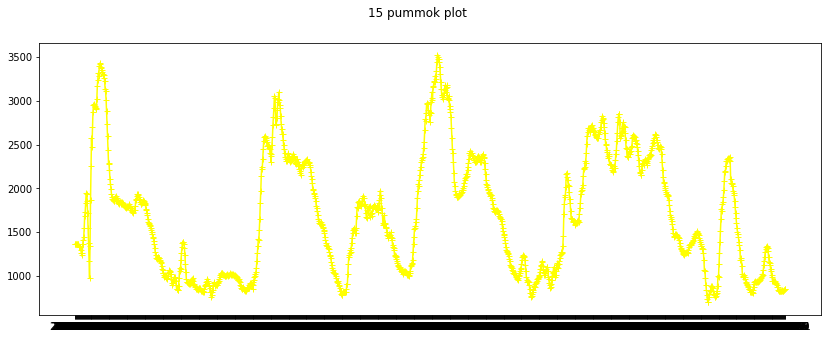

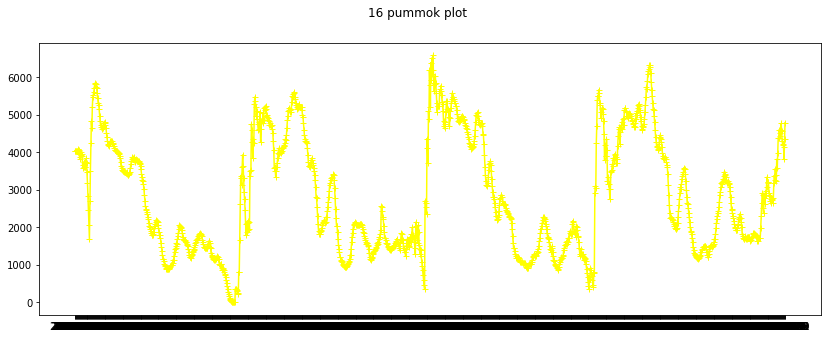

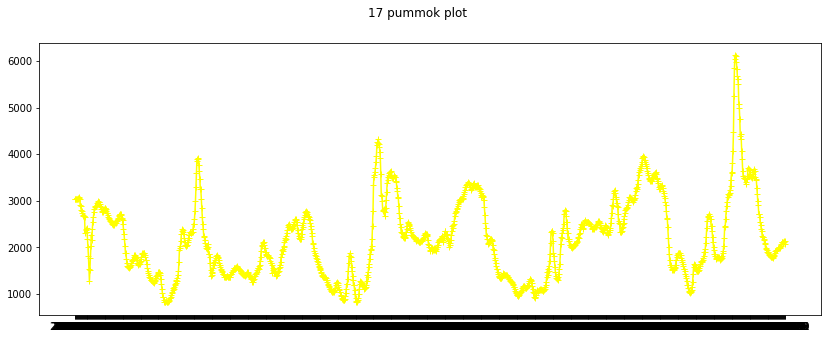

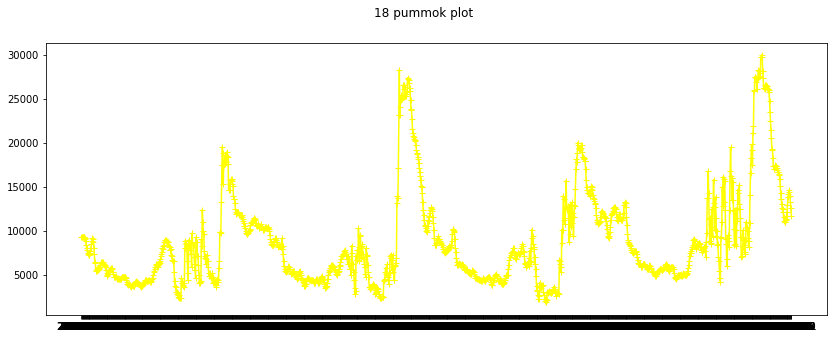

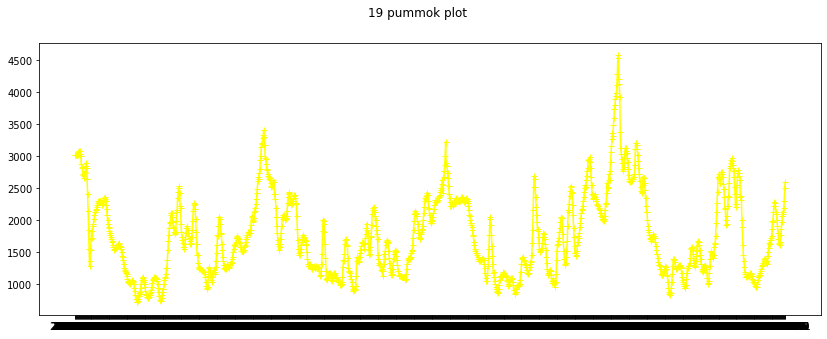

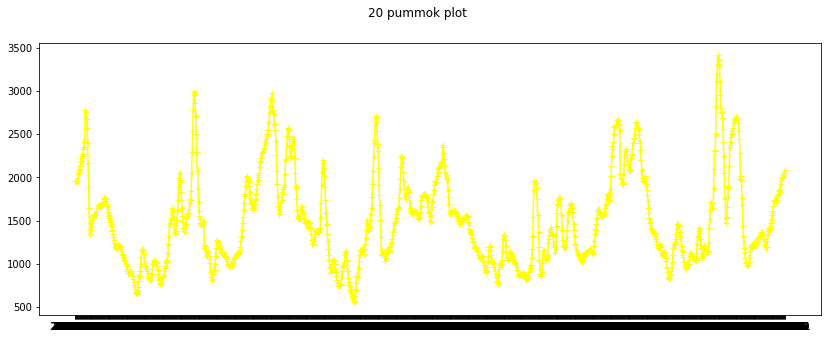

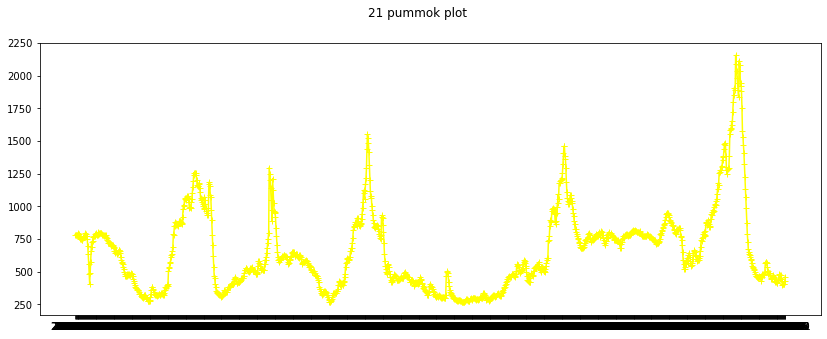

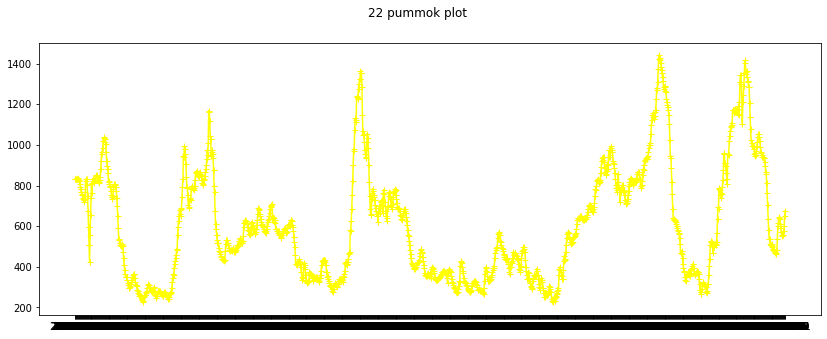

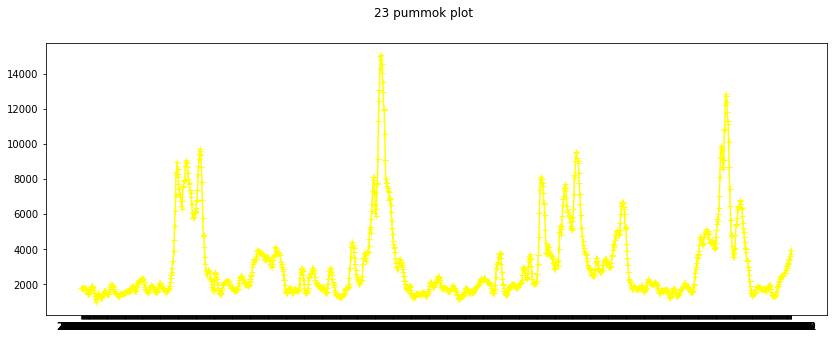

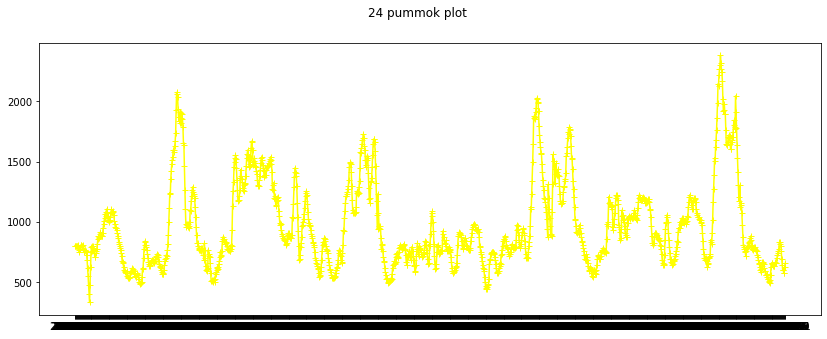

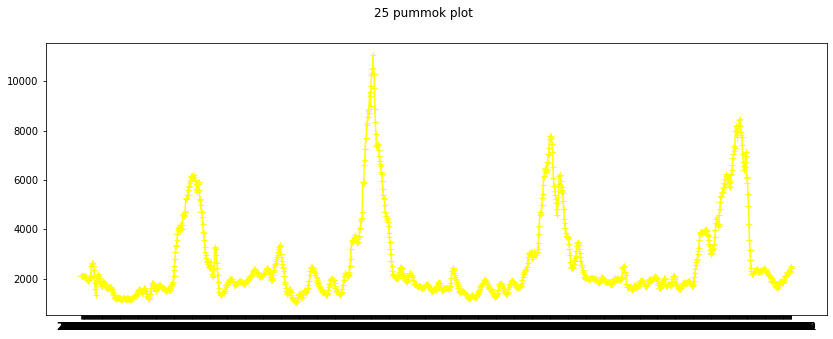

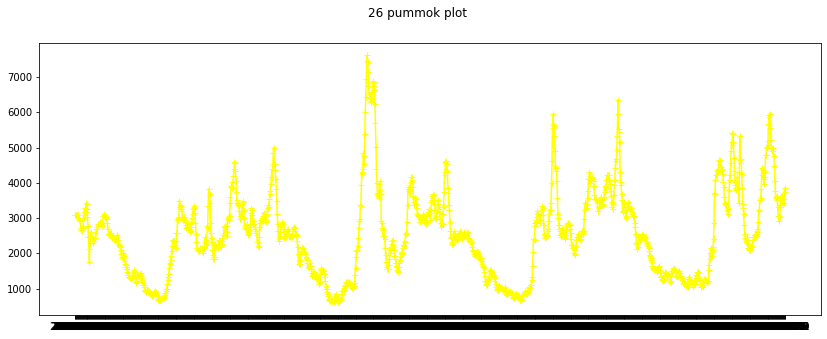

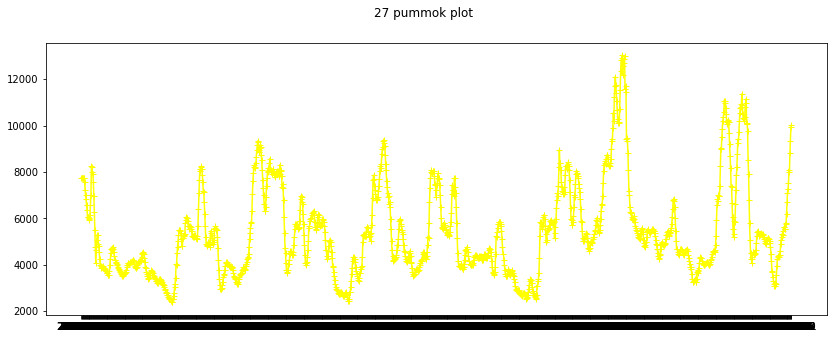

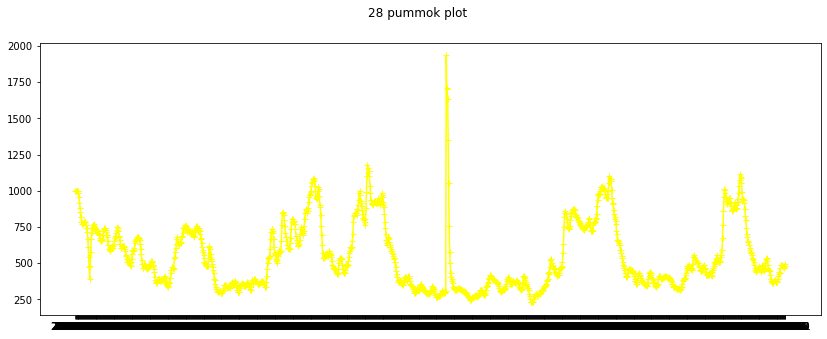

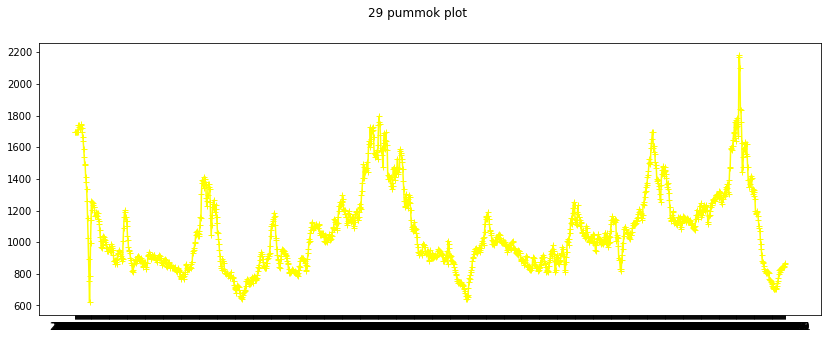

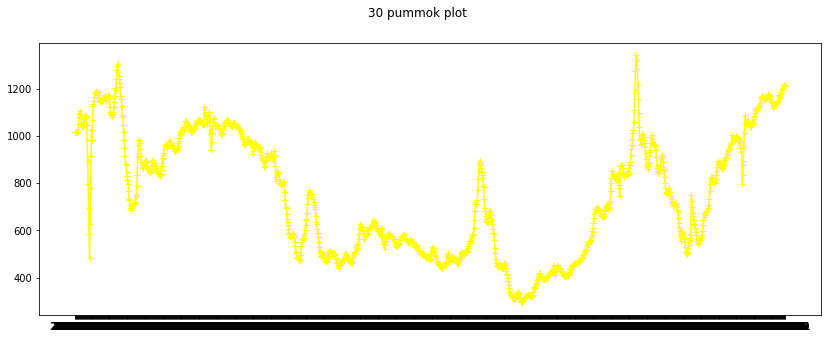

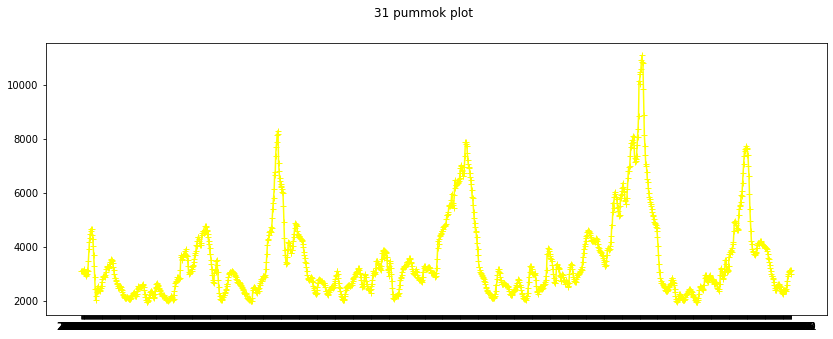

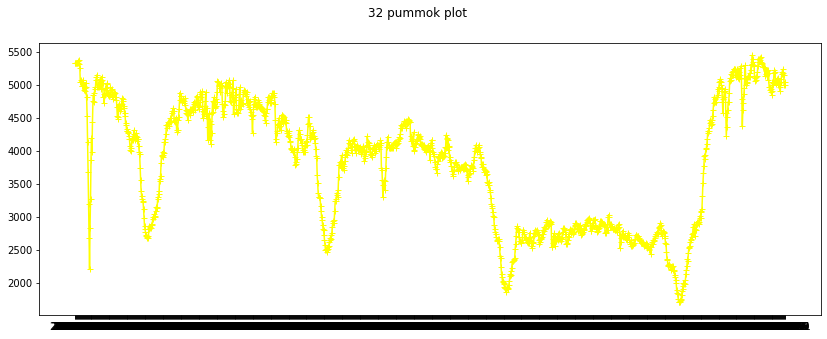

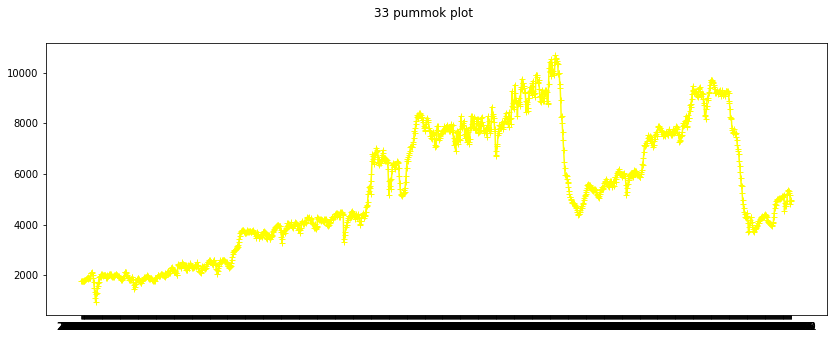

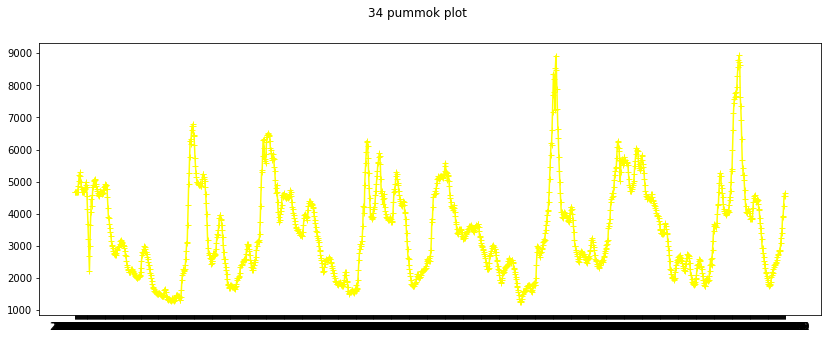

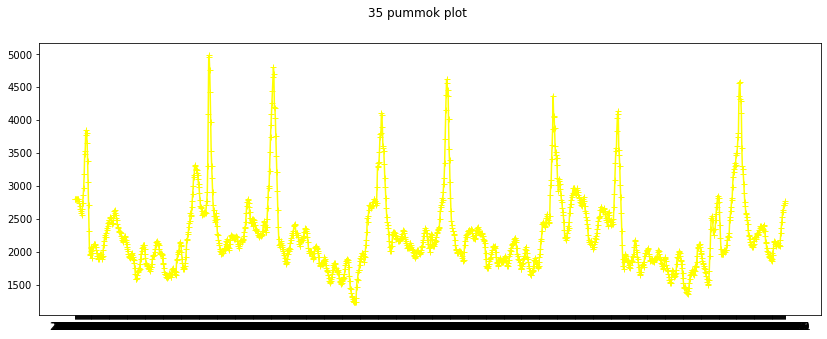

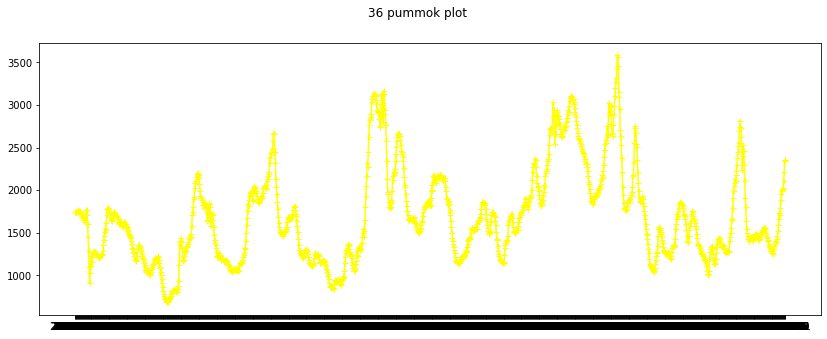

In [14]:
# 변경된거 한번 확인
for i in range(37):
  df= globals()[f'train_smoothing_{i}']
  plt.figure(figsize=(14,5))
  plt.plot(df['해당일자_전체평균가격(원)'], marker='+', color='yellow')
  #plt.plot(df['wma7'],  marker='*', color='yellow')
  # plt.plot(df['wma14'],  marker='s', color='yellow')

  plt.suptitle(f'{i} pummok plot')
  plt.show()
  plt.close()

In [15]:
# OLS Feature selection을 위한 함수
def OLS_report(df, seed):
    
    
    
    if len(df.columns)<len(train_smoothing_0.columns): # 주산지2의 날씨 데이터가 없다. 예외처리
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    else:
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+초기온도_2+최대온도_2+최저온도_2+ 평균온도_2+강수량_2+ 습도_2 +일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    return model.fit()




def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff
                              #  "conf_lower":conf_lower,
                              #  "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals"]]
    return results_df





def OLS_feature_selection(df):
  df.columns = df.columns.str.replace(r'\([^)]*\)','',regex= True) # 컬럼에서 문자 기호 같은거 있으면 OLS 안돌아간다.     
                                                                  # 테스트 데이터에도 적용해야한다. 컬럼명 바꿔야하니깐.
  result = OLS_report(df,42)
  ols_report_df = results_summary_to_dataframe(result).reset_index()
  ols_report_df = ols_report_df[ols_report_df['index'] !='Intercept']
  selected_col = list(ols_report_df[ols_report_df['pvals']<0.05]['index'].values) 
  selected_df = df[selected_col]
  selected_df['해당일자_전체평균가격'] = df['해당일자_전체평균가격']
  return selected_df        

In [16]:
# 유의수준을 토대로 columns selection
for i in range(37):
  globals()[f'total_{i}'] = OLS_feature_selection(globals()[f'train_smoothing_{i}'])

In [17]:
# 품목별로 컬럼 확인
for i in range(37):
  print(f"{i} 품목의 selected_columns : {list(globals()[f'total_{i}'].columns)}")

0 품목의 selected_columns : ['단가', '습도_0', '최저온도_1', '평균온도_1', '최대온도_2', '습도_2', '일자별_somae가격_최대', '일자별_somae가격_최소', '해당일자_전체평균가격']
1 품목의 selected_columns : ['단가', '거래량', '습도_0', '최대온도_1', '평균온도_1', '습도_1', '최대온도_2', '최저온도_2', '평균온도_2', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_somae가격_최대', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '해당일자_전체평균가격']
2 품목의 selected_columns : ['단가', '거래량', '최저온도_0', '습도_0', '최저온도_1', '최저온도_2', '습도_2', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입금액', '무역수지', '해당일자_전체평균가격']
3 품목의 selected_columns : ['단가', '거래량', '최저온도_1', '평균온도_1', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입중량', '수입금액', '무역수지', '해당일자_전체평균가격']
4 품목의 selected_columns : ['단가', '거래량', '최저온도_0', '최저온도_2', '습도_2', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_최소', '수출중량', '무역수지', '해당일자_전체평균가격']
5 품목의 selected_columns : ['단가', '거래량', '최대온도_0', '평균온도_0', '평균온도_1', '습도_1', '최대온도_2', '일자별_domae가격_평균', 

In [18]:
for i in range(37):
  print(globals()[f'total_{i}']['해당일자_전체평균가격'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [19]:
def scaling_df(df):
  scaler = StandardScaler()
  
  
  tmp = df.drop('해당일자_전체평균가격',axis=1).copy()
  scaler.fit(tmp)
  df_scaled = scaler.transform(tmp)
  df_scaled = pd.DataFrame(data=df_scaled, columns = tmp.columns)
  df_scaled['해당일자_전체평균가격'] = df['해당일자_전체평균가격'].values 
  return df_scaled

for i in range(37):
  globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])

In [20]:
for i in range(37):
  print(globals()[f'train_scaled_{i}'].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [21]:
globals()[f'train_scaled_0']

,단가,습도_0,최저온도_1,평균온도_1,최대온도_2,습도_2,일자별_somae가격_최대,일자별_somae가격_최소,해당일자_전체평균가격
0,-1.562158,0.0,-0.839649,-1.055373,-0.883624,0.232086,-1.324653,-1.342761,6114.961048
1,6.636992,0.0,-0.606699,-0.673602,-0.789047,-0.017175,0.577939,0.777304,6114.961048
2,0.611502,0.0,-0.723174,-0.883576,-0.949829,-0.391066,0.577939,0.777304,6114.961048
3,1.017981,0.0,-0.785891,-0.845399,-0.770131,0.120809,0.577939,0.777304,6114.961048
4,1.516286,0.0,-0.839649,-0.902665,-0.940371,-0.773859,0.577939,0.777304,6114.961048
...,...,...,...,...,...,...,...,...,...
1456,-1.562158,0.0,-0.741093,-0.959930,-0.817420,-0.017175,-1.324653,-1.342761,7669.473042
1457,1.422662,0.0,-0.606699,-0.664058,-0.580976,0.427934,1.532417,0.856559,7334.439109
1458,1.433806,0.0,-0.785891,-1.084005,-1.309223,1.327053,1.532417,0.856559,7132.553300
1459,1.881196,0.0,-1.529540,-1.866634,-2.207711,-1.299087,1.532417,0.856559,6946.171088


In [22]:
try_cnt = 16 # 모델이나 체크포인트를 각자 다른 폴더에 저장해주기 위해
            # 새로운거 시도할때마다 숫자 바꿔서 내면된다.


In [23]:
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [24]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [25]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(28)(x) # 4주 예측
    return keras.Model(inputs, outputs)

In [26]:
def call_back_set(name, epoch, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=100)

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}') == False:
        os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}')

    filename = f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/{name}-{epoch}-{batch_size}.h5'

    checkpoint = ModelCheckpoint(filename,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto'
                                 )
    return [early_stopping, checkpoint]

In [27]:
def train(x_train, y_train, x_val, y_val, name, epoch, batch_size, learning_rate = 0.001, verbose = 1):


    model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )


    # Train the model
    with tf.device('/device:GPU:0'):
        history1 = model.fit(
            x_train, y_train,
            epochs = epoch,
            steps_per_epoch=len(x_train) / batch_size,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            validation_steps=len(x_val) / batch_size,
            shuffle=False,
            callbacks=call_back_set(name, epoch, batch_size),
            verbose=verbose)

    return model

In [28]:
def time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in tqdm(range(len(df) - seqence_length)):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

In [29]:
epoch = 1000
batch = 15

In [30]:
for i in range(8, 37):


    df_number = i
    df = globals()[f'train_scaled_{i}']
    
    # nan 처리
    df.fillna(0, inplace = True)
    
  

    

    # 변수와 타겟 분리
    x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격']], df['해당일자_전체평균가격']

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # time series window 생성
    data_x = time_window(x, 13, 1)
    data_y = time_window(y, 27, 1)

    # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    # train, validation 분리 (8 : 2)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=False, random_state=119)

    # transformer 모델 훈련
    transformer = train(astype_data(x_train), y_train, astype_data(x_val), y_val, f'transformer-{df_number}', epoch, batch)
    transformer.load_weights(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}') == False:
         os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}')

    
    
    
    # 모델 저장
    transformer.save(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

100%|██████████| 1419/1419 [00:00<00:00, 22080.77it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 9127335.0000
Epoch 1: val_loss improved from inf to 2756424.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-0-1000-15.h5
75/75 [==============================] - 18s 34ms/step - loss: 9127335.0000 - val_loss: 2756424.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 1379588.6250
Epoch 2: val_loss improved from 2756424.00000 to 643581.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-0-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1380514.8750 - val_loss: 643581.2500
Epoch 3/1000
75/75 [============================>.] - ETA: 0s - loss: 1535544.7500
Epoch 3: val_loss did not improve from 643581.25000
75/75 [==============================] - 1s 16ms/step - loss: 1525525.0000 - val_loss: 685287.6875
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 1372486.0000
Epoch 4: val_loss did not im

100%|██████████| 1419/1419 [00:00<00:00, 23165.55it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 1972641.0000
Epoch 1: val_loss improved from inf to 214889.14062, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-1-1000-15.h5
75/75 [==============================] - 6s 30ms/step - loss: 1972641.0000 - val_loss: 214889.1406
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 498879.1875
Epoch 2: val_loss improved from 214889.14062 to 109065.36719, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-1-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 484752.8750 - val_loss: 109065.3672
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 518772.8438
Epoch 3: val_loss improved from 109065.36719 to 104361.24219, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-1-1000-15.h5
75/75 [==============================] - 2s 21ms/step - loss: 502797.3750 - val_loss: 104361.2422
Epoch 4/1000
73/75 [===

100%|██████████| 1419/1419 [00:00<00:00, 21666.95it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 3157033.7500
Epoch 1: val_loss improved from inf to 1556058.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-2-1000-15.h5
75/75 [==============================] - 6s 30ms/step - loss: 3157033.7500 - val_loss: 1556058.5000
Epoch 2/1000
75/75 [============================>.] - ETA: 0s - loss: 314124.3438
Epoch 2: val_loss did not improve from 1556058.50000
75/75 [==============================] - 1s 16ms/step - loss: 313549.0625 - val_loss: 2092371.1250
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 328918.4062
Epoch 3: val_loss did not improve from 1556058.50000
75/75 [==============================] - 1s 16ms/step - loss: 322723.7812 - val_loss: 2287481.2500
Epoch 4/1000
76/75 [==============================] - ETA: 0s - loss: 289131.0625
Epoch 4: val_loss did not improve from 1556058.50000
75/75 [==============================] - 1s 16ms/step - loss: 289131.0625 

100%|██████████| 1419/1419 [00:00<00:00, 22509.26it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 3267968.0000
Epoch 1: val_loss improved from inf to 928536.68750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-3-1000-15.h5
75/75 [==============================] - 7s 31ms/step - loss: 3267968.0000 - val_loss: 928536.6875
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 379356.4062
Epoch 2: val_loss did not improve from 928536.68750
75/75 [==============================] - 1s 16ms/step - loss: 373521.8438 - val_loss: 2104067.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 355938.2500
Epoch 3: val_loss did not improve from 928536.68750
75/75 [==============================] - 1s 16ms/step - loss: 349860.9062 - val_loss: 2128256.0000
Epoch 4/1000
75/75 [============================>.] - ETA: 0s - loss: 335992.9062
Epoch 4: val_loss did not improve from 928536.68750
75/75 [==============================] - 1s 16ms/step - loss: 333664.2812 - val

100%|██████████| 1419/1419 [00:00<00:00, 21345.10it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 2933613.7500
Epoch 1: val_loss improved from inf to 467420.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-4-1000-15.h5
75/75 [==============================] - 6s 30ms/step - loss: 2933613.7500 - val_loss: 467420.3750
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 612373.5625
Epoch 2: val_loss improved from 467420.37500 to 384104.43750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-4-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 612373.5625 - val_loss: 384104.4375
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 576157.4375
Epoch 3: val_loss improved from 384104.43750 to 378518.53125, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-4-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 576157.4375 - val_loss: 378518.5312
Epoch 4/1000
73/75 [===

100%|██████████| 1419/1419 [00:00<00:00, 22536.45it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 14561240.0000
Epoch 1: val_loss improved from inf to 4793117.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-5-1000-15.h5
75/75 [==============================] - 7s 30ms/step - loss: 14561240.0000 - val_loss: 4793117.0000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 2362630.2500
Epoch 2: val_loss improved from 4793117.00000 to 1383702.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-5-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 2362630.2500 - val_loss: 1383702.5000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 1574003.5000
Epoch 3: val_loss improved from 1383702.50000 to 1314017.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-5-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1574003.5000 - val_loss: 1314017.0000
Epoch 4/1

100%|██████████| 1419/1419 [00:00<00:00, 21144.52it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 35920420.0000
Epoch 1: val_loss improved from inf to 45301048.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-6-1000-15.h5
75/75 [==============================] - 6s 30ms/step - loss: 35920420.0000 - val_loss: 45301048.0000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 22901238.0000
Epoch 2: val_loss improved from 45301048.00000 to 28682012.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-6-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 22901238.0000 - val_loss: 28682012.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 20428786.0000
Epoch 3: val_loss improved from 28682012.00000 to 26948736.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-6-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 19808354.0000 - val_loss: 26948736.00

100%|██████████| 1419/1419 [00:00<00:00, 22862.47it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 3687762.2500
Epoch 1: val_loss improved from inf to 4623192.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-7-1000-15.h5
75/75 [==============================] - 7s 30ms/step - loss: 3687762.2500 - val_loss: 4623192.0000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 1381832.5000
Epoch 2: val_loss improved from 4623192.00000 to 2394359.75000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-7-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1381832.5000 - val_loss: 2394359.7500
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 1079824.0000
Epoch 3: val_loss improved from 2394359.75000 to 2270374.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-7-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1079824.0000 - val_loss: 2270374.5000
Epoch 4/100

100%|██████████| 1419/1419 [00:00<00:00, 22256.15it/s]


Epoch 1/1000
75/75 [============================>.] - ETA: 0s - loss: 10395151.0000
Epoch 1: val_loss improved from inf to 2595691.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-8-1000-15.h5
75/75 [==============================] - 6s 30ms/step - loss: 10307226.0000 - val_loss: 2595691.2500
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 947791.2500
Epoch 2: val_loss improved from 2595691.25000 to 1110258.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-8-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 947791.2500 - val_loss: 1110258.6250
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 751148.9375
Epoch 3: val_loss improved from 1110258.62500 to 978698.93750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-8-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 754713.3125 - val_loss: 978698.9375
Epoch 4/1000
75

100%|██████████| 1419/1419 [00:00<00:00, 21994.11it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 1763257.8750
Epoch 1: val_loss improved from inf to 201459.09375, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-9-1000-15.h5
75/75 [==============================] - 6s 31ms/step - loss: 1763257.8750 - val_loss: 201459.0938
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 135040.5312
Epoch 2: val_loss improved from 201459.09375 to 58971.59375, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-9-1000-15.h5
75/75 [==============================] - 2s 21ms/step - loss: 133642.0312 - val_loss: 58971.5938
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 137670.1562
Epoch 3: val_loss did not improve from 58971.59375
75/75 [==============================] - 1s 18ms/step - loss: 136391.4062 - val_loss: 59791.6602
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 126132.5625
Epoch 4: val_loss did not improve from 58

100%|██████████| 1419/1419 [00:00<00:00, 21655.13it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 1939340.7500
Epoch 1: val_loss improved from inf to 267577.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-10-1000-15.h5
75/75 [==============================] - 7s 25ms/step - loss: 1939340.7500 - val_loss: 267577.5625
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 161685.2344
Epoch 2: val_loss improved from 267577.56250 to 123898.50781, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-10-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 160928.4219 - val_loss: 123898.5078
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 138781.1250
Epoch 3: val_loss improved from 123898.50781 to 85226.35156, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-10-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 138843.7188 - val_loss: 85226.3516
Epoch 4/1000
75/75 [==

100%|██████████| 1419/1419 [00:00<00:00, 21787.20it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 14501775.0000
Epoch 1: val_loss improved from inf to 10811334.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-11-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 14501775.0000 - val_loss: 10811334.0000
Epoch 2/1000
75/75 [============================>.] - ETA: 0s - loss: 4331241.5000
Epoch 2: val_loss improved from 10811334.00000 to 2037701.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-11-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 4361488.5000 - val_loss: 2037701.3750
Epoch 3/1000
75/75 [============================>.] - ETA: 0s - loss: 1978914.1250
Epoch 3: val_loss improved from 2037701.37500 to 1721156.12500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-11-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1998117.5000 - val_loss: 1721156.1250
Epo

100%|██████████| 1419/1419 [00:00<00:00, 21562.08it/s]


Epoch 1/1000
74/75 [============================>.] - ETA: 0s - loss: 8723378.0000
Epoch 1: val_loss improved from inf to 2175285.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-12-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 8544342.0000 - val_loss: 2175285.5000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 670774.3750
Epoch 2: val_loss improved from 2175285.50000 to 906800.68750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-12-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 654066.3125 - val_loss: 906800.6875
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 655899.7500
Epoch 3: val_loss improved from 906800.68750 to 894412.68750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-12-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 645602.5000 - val_loss: 894412.6875
Epoch 4/1000
75/7

100%|██████████| 1419/1419 [00:00<00:00, 20241.46it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 4683365.0000
Epoch 1: val_loss improved from inf to 1483251.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-13-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 4538702.5000 - val_loss: 1483251.3750
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 995521.2500
Epoch 2: val_loss improved from 1483251.37500 to 177139.29688, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-13-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 985323.1250 - val_loss: 177139.2969
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 667325.7500
Epoch 3: val_loss improved from 177139.29688 to 150432.15625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-13-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 669789.7500 - val_loss: 150432.1562
Epoch 4/1000
76/7

100%|██████████| 1419/1419 [00:00<00:00, 19763.30it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 52376416.0000
Epoch 1: val_loss improved from inf to 27204278.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-14-1000-15.h5
75/75 [==============================] - 6s 24ms/step - loss: 50629152.0000 - val_loss: 27204278.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 4977198.0000
Epoch 2: val_loss improved from 27204278.00000 to 6587636.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-14-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 5198238.5000 - val_loss: 6587636.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 5433484.5000
Epoch 3: val_loss improved from 6587636.50000 to 6581621.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-14-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 5572747.0000 - val_loss: 6581621.5000
Epo

100%|██████████| 1419/1419 [00:00<00:00, 19000.93it/s]


Epoch 1/1000
74/75 [============================>.] - ETA: 0s - loss: 3080016.2500
Epoch 1: val_loss improved from inf to 526773.43750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-15-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 3087518.7500 - val_loss: 526773.4375
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 903423.1875
Epoch 2: val_loss did not improve from 526773.43750
75/75 [==============================] - 1s 16ms/step - loss: 877803.0000 - val_loss: 663667.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 473770.1562
Epoch 3: val_loss did not improve from 526773.43750
75/75 [==============================] - 1s 17ms/step - loss: 462640.5938 - val_loss: 538617.7500
Epoch 4/1000
76/75 [==============================] - ETA: 0s - loss: 435218.1250
Epoch 4: val_loss improved from 526773.43750 to 468094.43750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transform

100%|██████████| 1419/1419 [00:00<00:00, 21867.33it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 9361164.0000
Epoch 1: val_loss improved from inf to 3643676.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-16-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 9361164.0000 - val_loss: 3643676.2500
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 1644918.8750
Epoch 2: val_loss improved from 3643676.25000 to 1066867.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-16-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1644918.8750 - val_loss: 1066867.6250
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 1000815.5000
Epoch 3: val_loss improved from 1066867.62500 to 977268.18750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-16-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 1013663.0000 - val_loss: 977268.1875
Epoch 4/10

100%|██████████| 1419/1419 [00:00<00:00, 20500.68it/s]


Epoch 1/1000
75/75 [============================>.] - ETA: 0s - loss: 3569867.5000
Epoch 1: val_loss improved from inf to 1307258.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-17-1000-15.h5
75/75 [==============================] - 6s 25ms/step - loss: 3549866.5000 - val_loss: 1307258.2500
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 980979.8125
Epoch 2: val_loss did not improve from 1307258.25000
75/75 [==============================] - 1s 17ms/step - loss: 980979.8125 - val_loss: 1417116.2500
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 663182.0000
Epoch 3: val_loss did not improve from 1307258.25000
75/75 [==============================] - 1s 17ms/step - loss: 679494.1250 - val_loss: 2204851.2500
Epoch 4/1000
76/75 [==============================] - ETA: 0s - loss: 767547.8125
Epoch 4: val_loss improved from 1307258.25000 to 1267023.87500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/t

100%|██████████| 1419/1419 [00:00<00:00, 22067.34it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 86232520.0000
Epoch 1: val_loss improved from inf to 157851312.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-18-1000-15.h5
75/75 [==============================] - 6s 24ms/step - loss: 84818232.0000 - val_loss: 157851312.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 35793512.0000
Epoch 2: val_loss improved from 157851312.00000 to 61420824.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check16/transformer-18-1000-15.h5
75/75 [==============================] - 1s 18ms/step - loss: 34710940.0000 - val_loss: 61420824.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 29627410.0000
Epoch 3: val_loss did not improve from 61420824.00000
75/75 [==============================] - 1s 16ms/step - loss: 28747308.0000 - val_loss: 67004524.0000
Epoch 4/1000
75/75 [============================>.] - ETA: 0s - loss: 28297186.0000
Epoch 

KeyboardInterrupt: ignored

In [ ]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    

    # 정규 표현식 적용
    globals()[f'test_total_sep_{i}_{j}'].columns = globals()[f'test_total_sep_{i}_{j}'].columns.str.replace(r'\([^)]*\)','',regex= True)

    # 스케일링 & 타겟값 변환
    #globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])
    globals()[f'test_total_sep_{i}_{j}'] = scaling_df(globals()[f'test_total_sep_{i}_{j}'])

    # train 데이터랑 똑같이 selection
    globals()[f'test_total_sep_{i}_{j}'] = globals()[f'test_total_sep_{i}_{j}'][list(globals()[f'train_scaled_{j}'].columns)]

    

    # 해당일자평균가격 테스트 데이터에서는 타겟값 없애고 돌리네
    globals()[f'test_total_sep_{i}_{j}'].drop('해당일자_전체평균가격',axis=1, inplace=True)


    file_number = j

    # nan 처리
    globals()[f'test_total_sep_{i}_{j}'].fillna(0, inplace = True)
    # 형상 맞추기 코드는 아직 넣지 않았다. (안넣어도 되지 않을까?)

    # x_test 생성
    df_test = astype_data(globals()[f'test_total_sep_{i}_{j}'].values.reshape(1, globals()[f'test_total_sep_{i}_{j}'].values.shape[0], globals()[f'test_total_sep_{i}_{j}'].values.shape[1]))



    # model test
    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}')

    # 해당하는 모델 불러오기
    model_test = tf.keras.models.load_model(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{file_number}-{epoch}-{batch}.h5')
    pred = model_test.predict(df_test)


    # 여기서 다시 형변환 해주자!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!np.expm1
    # pred = np.expm1(pred)

    

    # 결과 저장
    save_df = pd.DataFrame(pred).T
    save_df.to_csv(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}/predict_{file_number}.csv', index=False)


In [ ]:
# 이부분 세부적으로 다 바꿔야한다.



for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

In [ ]:
pd.options.display.max_columns=37
set_df_0

In [ ]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

In [ ]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

In [ ]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv(f'/content/drive/MyDrive/농산물예측/submit{try_cnt}.csv',index=False)

In [ ]:
all_df

In [ ]:
out_ans

In [ ]:
submit_df